# Project : Predict Maize yield

> # Import Libraries & Read Dataset

In [1]:
import requests

url = 'https://raw.githubusercontent.com/lko9911/Kaggle/master/Compare_Regression_models.py'

r = requests.get(url)

with open('Compare_Regression_models.py', 'w') as f:
    f.write(r.text)

In [2]:
# For Compare modeling
from Compare_Regression_models import evaluate_models

# For Standard data
from sklearn.preprocessing import StandardScaler

# For Modeling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

# For Evaluate model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import r2_score

# For EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
df = pd.read_csv('/kaggle/input/worlds-wildlife/yields-of-important-staple-crops new.csv')
df

,country,code country,Year,Maize yield
0,United Kingdom,GBR,1275,0
1,United Kingdom,GBR,1305,0
2,United Kingdom,GBR,1355,0
3,United Kingdom,GBR,1405,0
4,United Kingdom,GBR,1455,0
...,...,...,...,...
13544,World,OWID_WRL,2022,5.7183
13545,Yemen,YEM,2022,1.1429
13546,Zambia,ZMB,2022,2.4261
13547,Zimbabwe,ZWE,2022,1.5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13549 entries, 0 to 13548
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   country       13549 non-null  object
 1   code country  13549 non-null  object
 2   Year          13549 non-null  int64 
 3   Maize yield   13501 non-null  object
dtypes: int64(1), object(3)
memory usage: 423.5+ KB


> # Data Preprocessing

In [5]:
df.isna().mean()

country         0.000000
code country    0.000000
Year            0.000000
Maize yield     0.003543
dtype: float64

In [6]:
df.dropna(inplace = True)

In [7]:
df['Maize yield'] = df['Maize yield'].str.replace('.', '').astype(int)
df['Maize yield']

0               0
1               0
2               0
3               0
4               0
           ...   
13544       57183
13545       11429
13546       24261
13547          15
13548    11127799
Name: Maize yield, Length: 13501, dtype: int64

 ### Since I don't have domain knowledge as to why Maize yield is "0", I will remove rows with zero yield.

In [8]:
maize_yield_zero = df[df['Maize yield'] == 0]

print(maize_yield_zero)

               country code country  Year  Maize yield
0       United Kingdom          GBR  1275            0
1       United Kingdom          GBR  1305            0
2       United Kingdom          GBR  1355            0
3       United Kingdom          GBR  1405            0
4       United Kingdom          GBR  1455            0
...                ...          ...   ...          ...
13480        Palestine          PSE  2022            0
13487        Polynesia     OWID_PYA  2022            0
13503  Solomon Islands          SLB  2022            0
13527          Tunisia          TUN  2022            0
13533   United Kingdom          GBR  2022            0

[1417 rows x 4 columns]


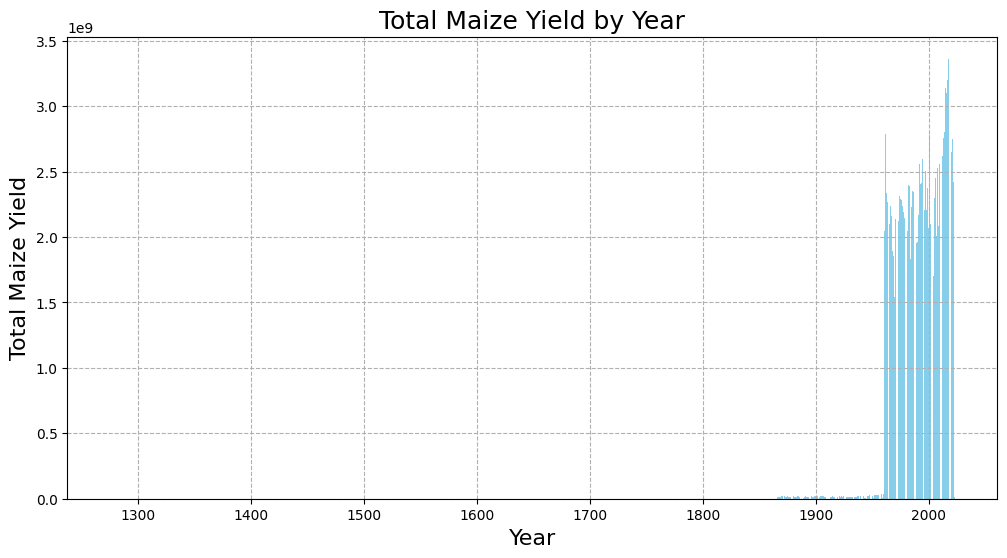

In [9]:
# EDA for "Maize yield"

yearly_yield = df.groupby('Year')['Maize yield'].sum().reset_index()

plt.figure(figsize=(12, 6))
plt.bar(yearly_yield['Year'], yearly_yield['Maize yield'], color='skyblue')
plt.xlabel('Year', fontsize=16)
plt.ylabel('Total Maize Yield', fontsize=16)
plt.title('Total Maize Yield by Year', fontsize=18)
plt.grid(linestyle='--')
plt.show()

In [10]:
df = df[df['Maize yield'] != 0]
df

,country,code country,Year,Maize yield
14,United States,USA,1866,15251298
15,United States,USA,1867,15502349
16,United States,USA,1868,16443787
17,United States,USA,1869,13682234
18,United States,USA,1870,18389425
...,...,...,...,...
13544,World,OWID_WRL,2022,57183
13545,Yemen,YEM,2022,11429
13546,Zambia,ZMB,2022,24261
13547,Zimbabwe,ZWE,2022,15


In [11]:
object_columns = df.select_dtypes(include=['object']).columns.tolist()

for col in object_columns:
    unique_count = df[col].nunique()
    print(f'{col} has {unique_count} unique values')

country has 221 unique values
code country has 178 unique values


In [12]:
for col in object_columns:
    unique_name = df[col].unique()
    print(f'{col} has {unique_name}')

country has ['United States' 'Afghanistan' 'Africa' 'Africa (FAO)' 'Albania' 'Algeria'
 'Americas (FAO)' 'Angola' 'Argentina' 'Asia' 'Asia (FAO)' 'Australia'
 'Austria' 'Bahamas' 'Bangladesh' 'Barbados' 'Belgium-Luxembourg (FAO)'
 'Belize' 'Benin' 'Bhutan' 'Bolivia' 'Botswana' 'Brazil' 'Bulgaria'
 'Burkina Faso' 'Burundi' 'Cambodia' 'Cameroon' 'Canada' 'Cape Verde'
 'Caribbean (FAO)' 'Central African Republic' 'Central America (FAO)'
 'Chad' 'Chile' 'China' 'Colombia' 'Comoros' 'Congo' 'Costa Rica'
 "Cote d'Ivoire" 'Cuba' 'Czechoslovakia' 'Democratic Republic of Congo'
 'Dominica' 'Dominican Republic' 'East Timor' 'Eastern Africa (FAO)'
 'Eastern Asia (FAO)' 'Eastern Europe (FAO)' 'Ecuador' 'Egypt'
 'El Salvador' 'Eswatini' 'Ethiopia (former)' 'Europe' 'Europe (FAO)'
 'European Union (27)' 'European Union (27) (FAO)' 'Fiji' 'France'
 'French Guiana' 'Gabon' 'Gambia' 'Germany' 'Ghana' 'Greece' 'Grenada'
 'Guadeloupe' 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti'
 'High-income co

In [13]:
df = df.drop('country', axis=1)
df = df[df['code country'] != '0']
df = df[~df['code country'].str.startswith('OWID_', na=False)]

In [14]:
df.dropna(inplace= True)

In [15]:
df = pd.get_dummies(df, columns=['code country'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9237 entries, 14 to 13548
Columns: 172 entries, Year to code country_ZWE
dtypes: bool(170), int64(2)
memory usage: 1.7 MB


In [16]:
X = df.drop(['Maize yield'], axis=1)
y = df['Maize yield']

evaluate_models(X,y)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.550e+17, tolerance: 3.957e+14
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008008 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 560
[LightGBM] [Info] Number of data points in the train set: 7389, number of used features: 159
[LightGBM] [Info] Start training from score 11610964.923400


,Model,RMSE,R2
0,Linear Regression,2.239168e+07,0.033856
1,Ridge Regression,2.239205e+07,0.033824
2,Lasso Regression,2.239211e+07,0.033819
3,ElasticNet,2.233234e+07,0.038970
4,Decision Tree Regressor,3.038584e+07,-0.779144
5,Random Forest Regressor,2.565000e+07,-0.267779
6,Support Vector Machine Regressor,2.551580e+07,-0.254547
7,K-Nearest Neighbors Regressor,2.332108e+07,-0.048011
8,Gradient Boosting Regressor,2.230041e+07,0.041716
9,XGBoost Regressor,2.306612e+07,-0.025221


> # Compare Model Conclusion

* ### Overall, the RMSE value is high
* ### The R2 value is below 0.1 and a negative value exists.
<br>

## Cause Analysis 
### 1. Underfitting: The model may be too simple or lack of flexibility to capture complex patterns in the data
### 2. Nonlinear Relationships in Data: can occur when the data has a nonlinear relationship rather than a linear relationship.
### 3. Lack of information(data) : Lack of information to make predictions
### 4. Or my mistake : Data Preprocessing, Lack of domain knowledge... 

# Thanks